In [64]:
#Import relevant libraries
import pandas as pd
import numpy as np


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

#import geopandas as gpd
#import geoplot as gplt

In [2]:
#Set visualization style & display
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
sns.color_palette("mako")
pd.set_option('display.max_columns', None)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#### Import Datasets

In [3]:
# 1) Import Training Data
trainset = pd.read_csv('Data/Training set values.csv')
trainset.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# 2) Import Training Data values
trainlabels = pd.read_csv('Data/Training set labels.csv')
trainlabels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
# 3) Import Test Data values
testset = pd.read_csv('Data/Test set values.csv')
testset.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2/4/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2/4/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2/1/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,1/22/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,3/27/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [6]:
#Verify Train/Test split
print("Train: ", trainset.shape, trainlabels.shape)
print("Test: ", testset.shape)


Train:  (59400, 40) (59400, 2)
Test:  (14850, 40)


In [7]:
#Check Column names
trainset.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [8]:
#Check for duplicates
print("Train Data: ", trainset.duplicated().sum())
print("Traing Labels: ", trainlabels.duplicated().sum())
print("Test Set: ", testset.duplicated().sum())

Train Data:  0
Traing Labels:  0
Test Set:  0


## Cleaning the Data

### Training Dataset

In [9]:
#Check DataFrame information
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Dealing with Null Values

In [10]:
#Check for null values
trainset.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

##### 1) Management Data

In [11]:
#'scheme_management' and 'management' columns seem to have similar entries

#Compare 'scheme_management' and 'management' column entries
trainset.scheme_management = trainset.scheme_management.str.lower() #Change entries to lowercase for comparison
print('Both entries are the same: ', trainset.loc[trainset.scheme_management == trainset.management].shape[0])
print('Both entries differ total: ', trainset.loc[trainset.scheme_management != trainset.management].shape[0])
print('Both entries differ (Only non-null): ', trainset.loc[(trainset.scheme_management != trainset.management) &
                                              (trainset.scheme_management.isna() == False)].shape[0])
print('Difference because of null value: ', trainset.scheme_management.isna().sum())

Both entries are the same:  49336
Both entries differ total:  10064
Both entries differ (Only non-null):  6187
Difference because of null value:  3877


In [12]:
print('Management: \n', trainset.management.value_counts(), '\n\n')
print('Operator (scheme_management): \n', trainset.scheme_management.value_counts())

Management: 
 vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64 


Operator (scheme_management): 
 vwc                 36793
wug                  5206
water authority      3153
wua                  2883
water board          2748
parastatal           1680
private operator     1063
company              1061
other                 766
swc                    97
trust                  72
none                    1
Name: scheme_management, dtype: int64


In [13]:
#The 'scheme_management' and 'management' columns are similar
#Replace the null values in 'scheme_management' with their equivalent in 'management'

indexmodlist = list(trainset.loc[trainset.scheme_management.isna() == True].index) #Compile list of indexes of null values
for index in indexmodlist:
    trainset.loc[index, 'scheme_management'] = trainset.loc[index, 'management'] #Replace with associated value

#Verify entries
print(trainset.scheme_management.isna().sum())
trainset.head()

0


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,vwc,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,vwc,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,vwc,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,other,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


##### 2) Funder v. Installer

In [14]:
#Compare 'funder' and 'installer' data

#Adjust entry format to better compare
trainset.funder = trainset.funder.str.title()
trainset.installer = trainset.installer.str.title()

#Compare entries
print('Both entries are the same: ', trainset.loc[trainset.funder == trainset.installer].shape[0])
print('Both entries differ total: ', trainset.loc[trainset.funder != trainset.installer].shape[0])
print('Both entries differ (non-null only): ', trainset.loc[(trainset.funder != trainset.installer) &
                                                           (trainset.funder.isna() == False) &
                                                           (trainset.installer.isna() == False)].shape[0])
print('Both entries are null: ', trainset.loc[(trainset.funder.isna() == True) & (trainset.installer.isna() == True)].shape[0])

Both entries are the same:  18930
Both entries differ total:  40470
Both entries differ (non-null only):  36762
Both entries are null:  3582


In [15]:
#Compare unique entries
print('Funder: \n', trainset.funder.value_counts(), '\n\n')
print('Installer: \n', trainset.installer.value_counts())

Funder: 
 Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Nyabweta                     1
Mzee Yassin Naya             1
Makona                       1
Hesawwa                      1
Rudri                        1
Name: funder, Length: 1897, dtype: int64 


Installer: 
 Dwe                    17405
Government              1891
Hesawa                  1395
Rwe                     1206
Commu                   1065
                       ...  
Dww                        1
Care  International        1
Heesaw                     1
Local Technical            1
College                    1
Name: installer, Length: 1935, dtype: int64


In [16]:
#Replace the null values with new 'Unknown' category
trainset.funder.fillna('Unknown', inplace = True)
trainset.installer.fillna('Unknown', inplace = True)

##### 3) Permit

In [17]:
#Check Values
trainset.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [18]:
trainset.permit.isna().sum()

3056

In [19]:
#Compare null values to data on funders, installers, operators and management
print('Installer or Funder Unknown: ', trainset.loc[(trainset.permit.isna() == True) &
            ((trainset.funder == 'Unknown' ) | (trainset.installer == 'Unknown'))].shape[0] )
print('Operator or Management Parastatal/Water Authority: ', trainset.loc[(trainset.permit.isna() == True) &
                                                      ((trainset.scheme_management == 'paastatal') |
                                                      (trainset.scheme_management == 'water authority') |
                                                      (trainset.management == 'parastatal') |
                                                      (trainset.management == 'water authority'))].shape[0])

Installer or Funder Unknown:  2424
Operator or Management Parastatal/Water Authority:  370


In the majority of cases of *unknown* permits, the funders and/or installers are *unknown*, so we can assume that there is no permit in these cases.
But, if the operator or management is parastatal or the water authority then a permit is assumed due to the connection with authorities. 

In [20]:
#Change null values according to assumptions above
indexmodlist = list(trainset.loc[trainset.permit.isna() == True].index) #Compile list of indexes of rows to change

for i in indexmodlist:
    if trainset.loc[i, 'scheme_management'] == 'parastatal':
        trainset.loc[i, 'permit'] = True
    elif trainset.loc[i, 'scheme_management'] == 'water authority':
        trainset.loc[i, 'permit'] = True
    elif trainset.loc[i, 'management'] == 'parastatal':
        trainset.loc[i, 'permit'] = True
    elif trainset.loc[i, 'management'] == 'water authority':
        trainset.loc[i, 'permit'] = True
    else:
        trainset.loc[i, 'permit'] = False

In [21]:
#Verify 'permit' Series for null values
print('Number of null values: ', trainset.permit.isna().sum())
trainset.permit.value_counts()

Number of null values:  0


True     39223
False    20177
Name: permit, dtype: int64

##### 4) Subvillage

In [22]:
#Check unique values 
trainset.subvillage.value_counts()

Madukani     508
Shuleni      506
Majengo      502
Kati         373
Mtakuja      262
            ... 
Unjeje         1
Ukunda         1
Nhungulu       1
Ngasani A      1
Ilambika       1
Name: subvillage, Length: 19287, dtype: int64

In [23]:
#The number of unique values is very large, while the number of null values is very low
#So best to create new 'Unknown' category rather than lose data

trainset.subvillage.fillna('Unknown', inplace = True)

##### 5) Public Meeting

In [24]:
trainset.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

'public_meeting' appears to be open to some degree of interpretation, but with the large majority of entries being 'True', the understood interpretation is that the water well in question is accessible to the public. In this case, the null values can likely be assumed to be 'True' as well. 

Furthermore, there doesn't seem to be an apparent connection between 'public_meeting' and either the managemenet, operatos, funders or installers at first glance, so the meaning is unlikely one of political significance. 

In [25]:
#Replace NaN with 'True' as more likely option
trainset.public_meeting.fillna('True', inplace = True)

#### Re-Check for null values

In [26]:
#Recheck training dataframe for null values
trainset.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management            0
scheme_name              28166
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### Drop unnecessary and/or uninteresting columns

- `num_private` - data contained is unclear, only '0' values
- `recorded_by` - contains only one single constant entry ('GeoData Consultants Ltd'), so it's not interestng for analysis purposes
- `date_recorded` - the data provides an interesting point of chronological reference for the geopolitical situation in Tanzania, but doesn't serve much purpose in the DataFrame for present purposes. 

***The recorded years are split as follows:*** `{'2011': 28674, '2013': 24271, '2012': 6424, '2004': 30, '2002': 1}`

- `scheme_name` - this columns contains a very large number of null values and unique entries. In addition, there is already another column (`scheme_management`) that is labeled as indicating who operates the wells in question. There is also additionally the `management` and `management_group` Series for additional clarity on management.
- `extraction_type_group` - contains the same information as `extraction_type` and `extraction_type_group`. The former is the most specific breakdown, while the latter groups extraction along more manageble categories. Both of these can be explored, which leaves `extraction_type_group` in the middle with little purpose. 
- `payment type` - contains the exact same information as `payment`.
- `quality group` - contains the same information as `water quality`, with a few differences ("good" instead of "soft", and `water quality` furthe differentiates between 'salty' and 'salty abandoned', as well as 'fluoride' and 'fluoride abandoned'). 
- `quantity_goup` - contains the exact same entries as `quantity`. Only `quantity` will be kept. 
- `source_type` - this Series contains almost exactly the same entries as `source`, with the latter being more detailed in its categories. 
- `waterpoint_type_group` - this Series contains the exact same entries as `waterpoint_type`, with the exception that `waterpoint_type` provides the additional differential between '*communal standpipe*' and '*communal standpipe multiple*', therefore there is little purpose in keeping `waterpoing_type_group`


In [27]:
#Drop unnecessary and/or uninteresting columns
trainset.drop(['num_private', 'recorded_by', 'date_recorded', 'scheme_name', 'extraction_type_group', 
               'payment_type', 'quality_group', 'quantity', 
               'source_type', 'waterpoint_type_group'], axis = 1, inplace = True)

### Check the data types of each Series

In [28]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   funder                 59400 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              59400 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   basin                  59400 non-null  object 
 9   subvillage             59400 non-null  object 
 10  region                 59400 non-null  object 
 11  region_code            59400 non-null  int64  
 12  district_code          59400 non-null  int64  
 13  lga                    59400 non-null  object 
 14  ward                   59400 non-null  object 
 15  po

In [29]:
#Change boolean to categorical types
trainset.permit = trainset.permit.astype("category")

# Exploratory Data Analysis & Visualization

In [30]:
#Define function to create sub datafames for visualizations
def create_sg_subdf(seriesName, norm = True):
    """This function creates a workable dataframe 
    grouping a Series by status_group"""
    
    subdf = df.groupby('status_group')[seriesName].value_counts(normalize = norm).unstack()
    return subdf

In [31]:
#Join trainset and trainlabels DataFrames
df = pd.merge(trainlabels, trainset, on = 'id', how = 'inner')

In [32]:
df.head()

,id,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity_group,source,source_class,waterpoint_type
0,69572,functional,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,vwc,False,1999,gravity,gravity,vwc,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe
1,8776,functional,0.0,Grumeti,1399,Grumeti,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,other,True,2010,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe
2,34310,functional,25.0,Lottery Club,686,World Vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,vwc,True,2009,gravity,gravity,vwc,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe multiple
3,67743,non functional,0.0,Unicef,263,Unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,vwc,True,1986,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple
4,19728,functional,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,other,True,0,gravity,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe


### Looking at Functionality Status Group Spread

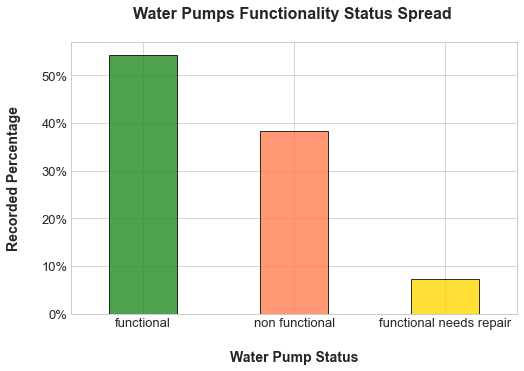

In [33]:
#Plot the status _group spread
ax = df.status_group.value_counts(normalize = True).plot(kind = 'bar', width = .45, figsize = (8, 5), 
                                                         color = ['forestgreen', 'coral', 'gold'],
                                                         edgecolor = 'black', alpha = .8)

#Format x- and y-axis
plt.xticks(fontsize = 13,  rotation = 0)
plt.xlabel('\nWater Pump Status', fontweight = 'bold', fontsize = 14 )
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.yticks(fontsize = 13)
plt.ylabel('Recorded Percentage\n', fontweight = 'bold', fontsize = 14)

#Format plot
plt.title('Water Pumps Functionality Status Spread \n', fontsize = 16, fontweight = 'bold');

There appears at first glance to be many non-functional water wells in the recorded Data

### Amount of Water Available to Waterpoint

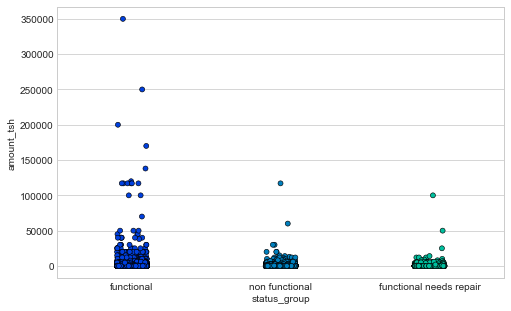

In [34]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.stripplot(x = 'status_group', y = 'amount_tsh', data = df, edgecolor = 'black', linewidth = .6,  ax = ax,
             palette = "winter");

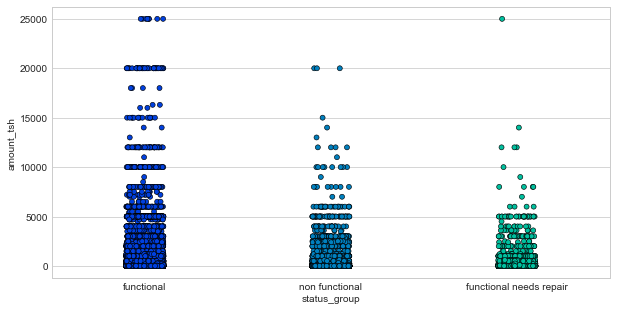

In [35]:
#Zooming in, by eliminating outliers
#Create working DataFrame
zoomeddf = df.loc[df['amount_tsh'] <= 25000]

#Plot water amount per category
fig, ax = plt.subplots(figsize = (10, 5))
sns.stripplot(x = 'status_group', y = 'amount_tsh',  data = zoomeddf,
              edgecolor = 'black', linewidth = .6,  ax = ax, palette = "winter");

In [36]:
#Compare mean per status group
df.groupby('status_group')['amount_tsh'].mean()

status_group
functional                 461.798235
functional needs repair    267.071577
non functional             123.481230
Name: amount_tsh, dtype: float64

Water amount does appear to have an effect on the functionality of the water wells. 

Looking further into the water characteristics, do the source, quality and quantity have an effect?

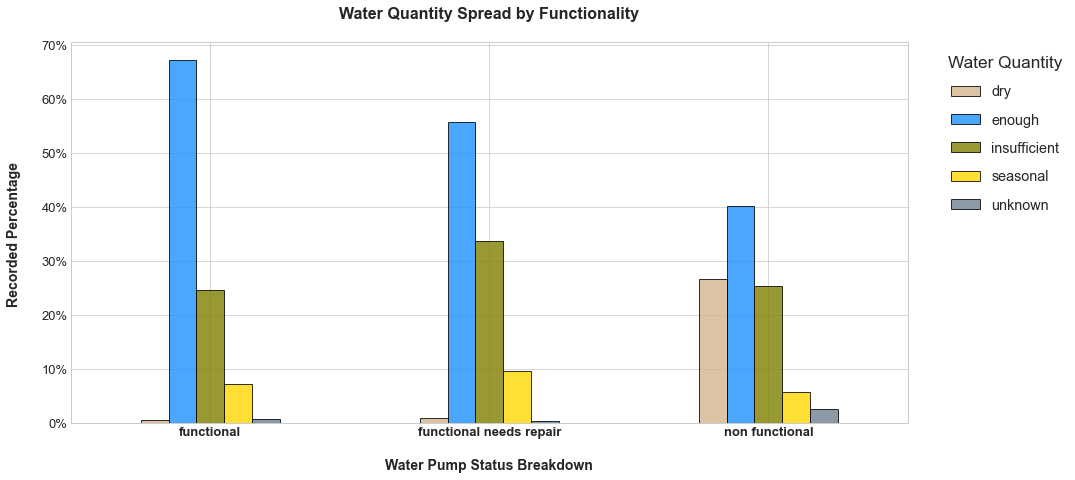

In [37]:
#Create a workable dataframe for quantity
quant = create_sg_subdf("quantity_group")

#Plot the quantity to status group
ax = quant.plot(kind = 'bar', figsize = (15, 7), alpha = .8, edgecolor = 'black', 
                color = ['tan', 'dodgerblue', 'olive', 'gold', 'slategray'])

#Format axis
plt.xticks(fontsize = 13, fontweight = 'bold', rotation = 0)
plt.xlabel('\nWater Pump Status Breakdown', fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

#Format plot
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Water Quantity',
          title_fontsize = 'xx-large', fontsize = 'x-large', labelspacing = 1)
plt.title("Water Quantity Spread by Functionality\n", fontsize = 16, fontweight = 'bold');

### Water Source

In [38]:
#Create a workable dataframe fror visualization
source1 = create_sg_subdf("source_class")
source2 = create_sg_subdf("source")

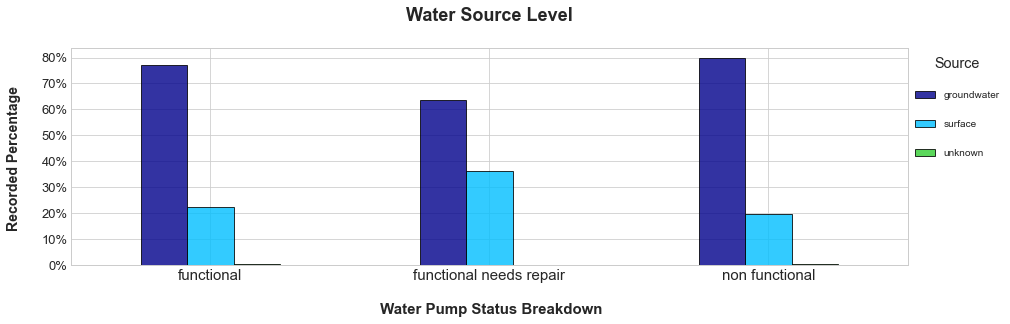

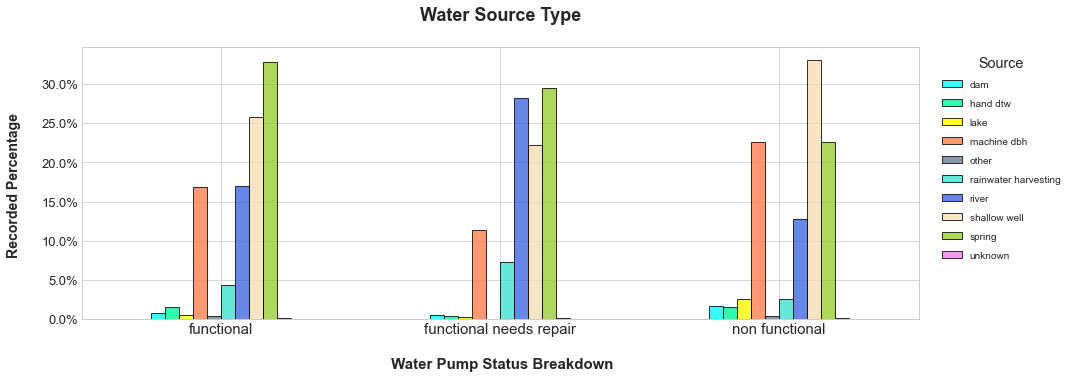

In [39]:
#Plot and Format source1
ax1 = source1.plot(kind = 'bar', figsize = (15, 4), edgecolor = 'black', color = ['darkblue', 'deepskyblue', 
                                                                                  'limegreen'], alpha = .8)

plt.xticks(fontsize = 15, rotation = 0)
plt.xlabel('\n Water Pump Status Breakdown', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

ax1.legend(loc = 'upper right', bbox_to_anchor = (1.12, 1), title = 'Source',
          title_fontsize = 'x-large', fontsize = 'medium', labelspacing = 2)
plt.title("Water Source Level\n", fontsize = 18, fontweight = 'bold');

#Plot and Format source2
ax2 = source2.plot(kind = 'bar', figsize = (15, 5), edgecolor = 'black', alpha = .8,
                  color = ['cyan', 'mediumspringgreen', 'yellow', 'coral', 'slategray', 
                          'turquoise', 'royalblue', 'wheat', 'yellowgreen', 'violet'])

plt.xticks(fontsize = 15, rotation = 0)
plt.xlabel('\n Water Pump Status Breakdown', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

ax2.legend(loc = 'upper right', bbox_to_anchor = (1.18, 1), title = 'Source',
          title_fontsize = 'x-large', fontsize = 'medium', labelspacing = 1)
plt.title("Water Source Type\n", fontsize = 18, fontweight = 'bold');

### Water Pumps Characteristics 

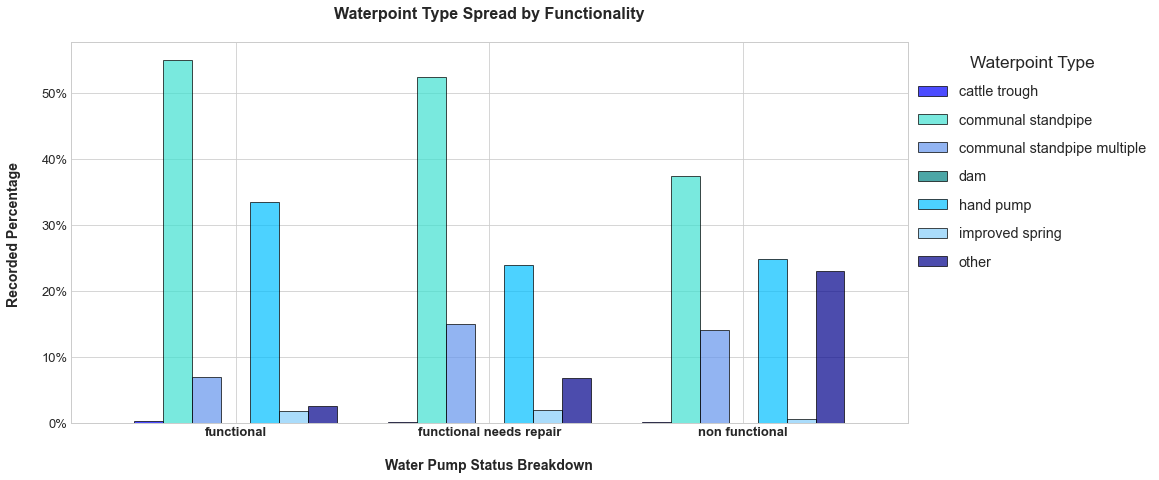

In [40]:
#Create workable datafame for visualization
wtp = create_sg_subdf('waterpoint_type')

#Plot the waterpoint type to status group
ax = wtp.plot(kind = 'bar', figsize = (15, 7), color = ['blue', 'turquoise', 'cornflowerblue', 'teal', 
                                                       'deepskyblue', 'lightskyblue', 'darkblue'], alpha = .7,
             width = .8, edgecolor = 'black')

#Format axis
plt.xticks(fontsize = 13, fontweight = 'bold', rotation = 0)
plt.xlabel('\nWater Pump Status Breakdown', fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

#Format plot
ax.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1), title = 'Waterpoint Type',
          title_fontsize = 'xx-large', fontsize = 'x-large', labelspacing = 1)
plt.title("Waterpoint Type Spread by Functionality\n", fontsize = 16, fontweight = 'bold');

### Water Quality

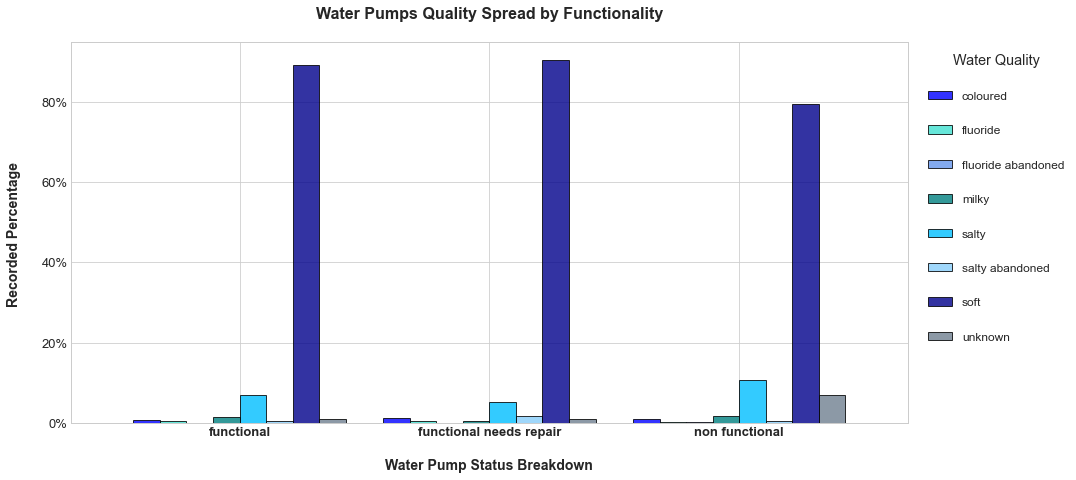

In [41]:
#Create workable dataframe
qual = create_sg_subdf('water_quality')

#Plot the waterpoint type to status group
ax = qual.plot(kind = 'bar', figsize = (15, 7), width = .85, alpha = .8, edgecolor = 'black', 
               color = ['blue', 'turquoise', 'cornflowerblue', 'teal', 
                        'deepskyblue', 'lightskyblue', 'darkblue', 'slategray'])

#Format axis
plt.xticks(fontsize = 13, fontweight = 'bold', rotation = 0)
plt.xlabel('\nWater Pump Status Breakdown', fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

#Format plot
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Water Quality',
          title_fontsize = 'x-large', fontsize = 'large', labelspacing = 2)
plt.title("Water Pumps Quality Spread by Functionality\n", fontsize = 16, fontweight = 'bold');

## Management and Operation

### Extraction Type

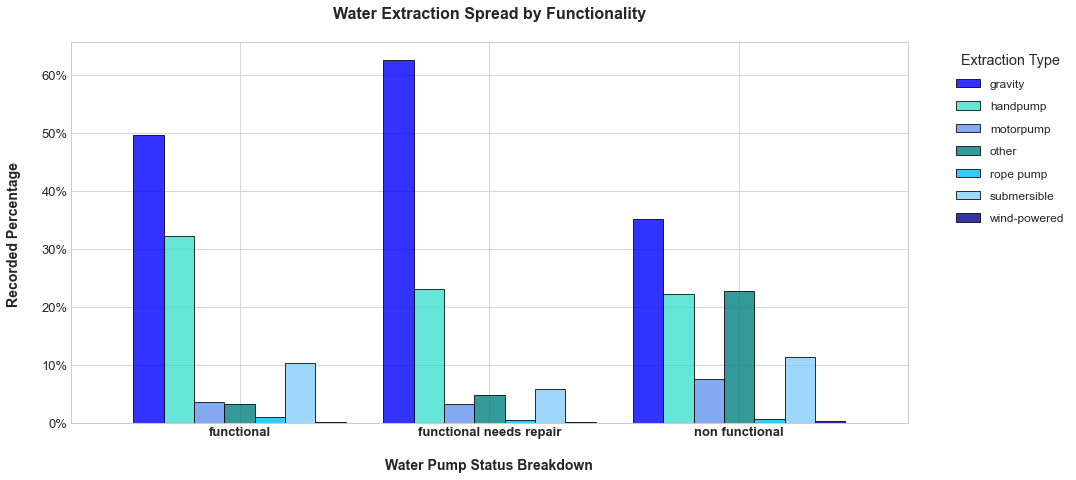

In [42]:
#Create workable dataframe
extrac = create_sg_subdf('extraction_type_class')

#Plot the waterpoint type to status group
ax = extrac.plot(kind = 'bar', figsize = (15, 7), width = .85, alpha = .8, edgecolor = 'black',
                color = ['blue', 'turquoise', 'cornflowerblue', 'teal', 
                                 'deepskyblue', 'lightskyblue', 'darkblue'])

#Format axis
plt.xticks(fontsize = 13, fontweight = 'bold', rotation = 0)
plt.xlabel('\nWater Pump Status Breakdown', fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

#Format plot
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Extraction Type',
          title_fontsize = 'x-large', fontsize = 'large', labelspacing = 1)
plt.title("Water Extraction Spread by Functionality\n", fontsize = 16, fontweight = 'bold');

### Management

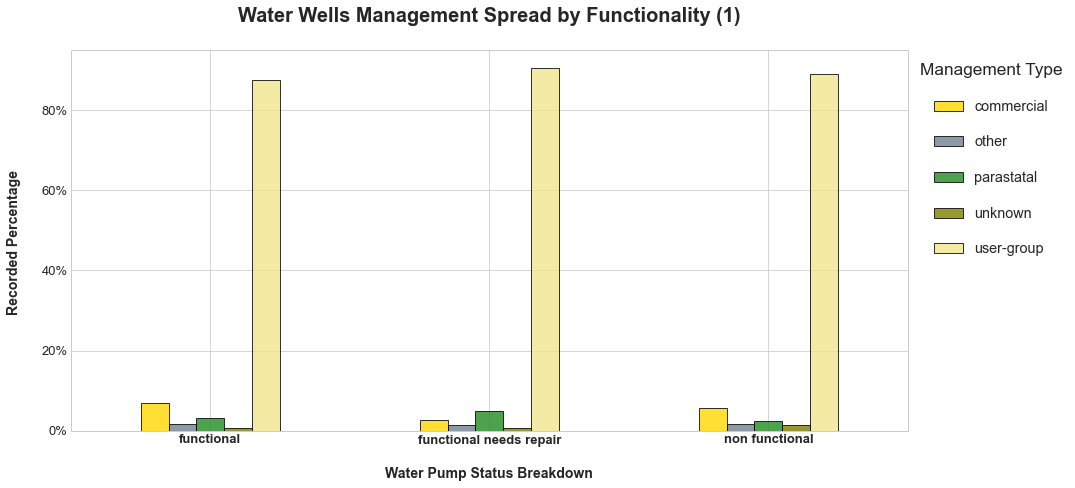

In [43]:
#Create workable dataframe
mgmt = create_sg_subdf('management_group')

#Plot the waterpoint type to status group
ax = mgmt.plot(kind = 'bar', figsize = (15, 7), width = .5, alpha = .8, edgecolor = 'black',
              color = ['gold', 'slategray', 'forestgreen', 'olive', 'khaki'])

#Format axis
plt.xticks(fontsize = 13, fontweight = 'bold', rotation = 0)
plt.xlabel('\nWater Pump Status Breakdown', fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

#Format plot
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Management Type',
          title_fontsize = 'xx-large', fontsize = 'x-large', labelspacing = 1.5)
plt.title("Water Wells Management Spread by Functionality (1)\n", fontsize = 20, fontweight = 'bold');

In [44]:
mgmt.head()

management_group,commercial,other,parastatal,unknown,user-group
status_group,,,,,
functional,0.069283,0.016368,0.031619,0.006944,0.875787
functional needs repair,0.027102,0.012972,0.048877,0.006254,0.904795
non functional,0.056344,0.015729,0.023528,0.013582,0.890817


In [45]:
#Created zoomed in df
mgmtzoom = mgmt.drop('user-group', axis = 1)

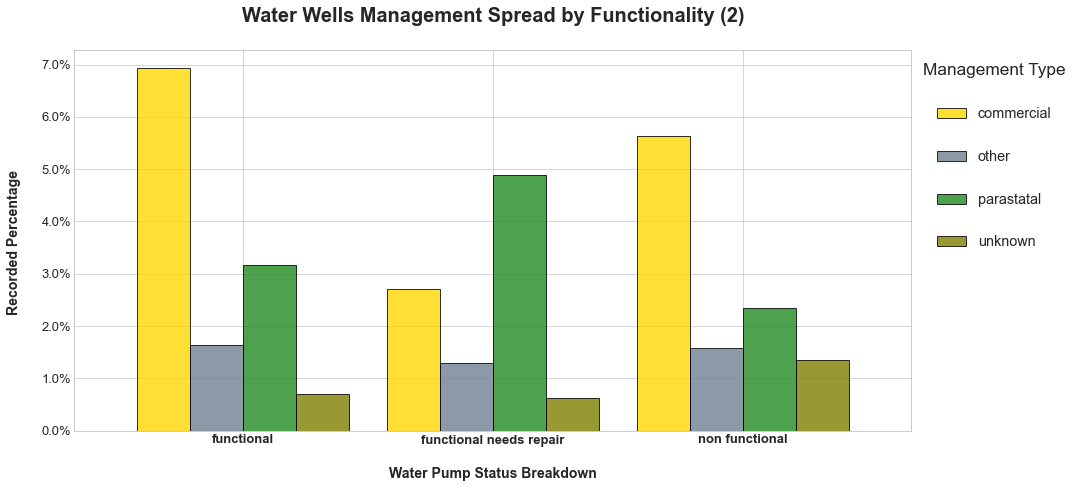

In [46]:
#Plot the waterpoint type to status group
ax = mgmtzoom.plot(kind = 'bar', figsize = (15, 7), width = .85, alpha = .8, edgecolor = 'black',
                  color = ['gold', 'slategray', 'forestgreen', 'olive'])

#Format axis
plt.xticks(fontsize = 13, fontweight = 'bold', rotation = 0)
plt.xlabel('\nWater Pump Status Breakdown', fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

#Format plot
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Management Type',
          title_fontsize = 'xx-large', fontsize = 'x-large', labelspacing = 2)
plt.title("Water Wells Management Spread by Functionality (2)\n", fontsize = 20, fontweight = 'bold');

### Payment Type

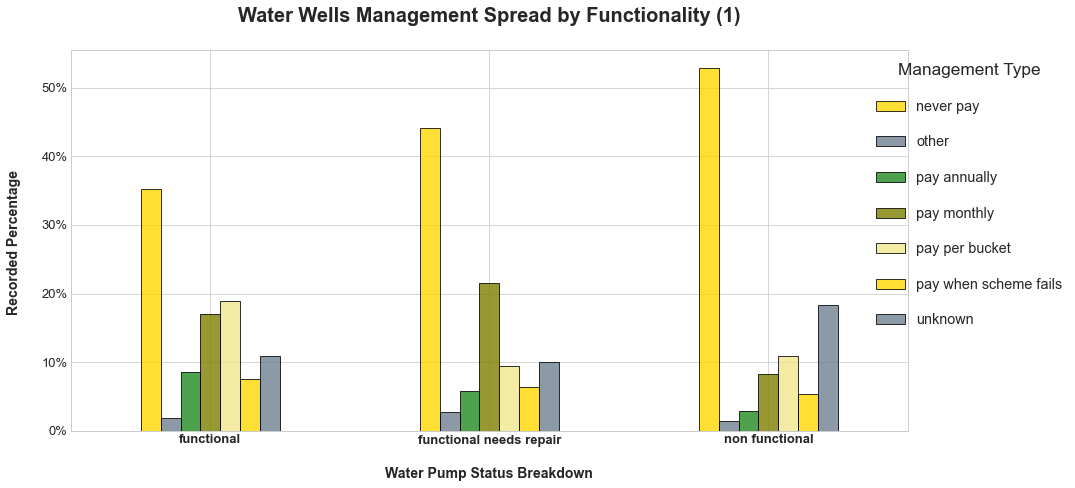

In [47]:
#Create workable dataframe
cost = create_sg_subdf('payment')

#Plot the waterpoint type to status group
ax = cost.plot(kind = 'bar', figsize = (15, 7), width = .5, alpha = .8, edgecolor = 'black',
              color = ['gold', 'slategray', 'forestgreen', 'olive', 'khaki'])

#Format axis
plt.xticks(fontsize = 13, fontweight = 'bold', rotation = 0)
plt.xlabel('\nWater Pump Status Breakdown', fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Recorded Percentage \n", fontweight = 'bold', fontsize = 14)

#Format plot
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Management Type',
          title_fontsize = 'xx-large', fontsize = 'x-large', labelspacing = 1.5)
plt.title("Water Wells Management Spread by Functionality (1)\n", fontsize = 20, fontweight = 'bold');

     status_group  longitude   latitude
0      functional  34.938093  -9.856322
1      functional  34.698766  -2.147466
2      functional  37.460664  -3.821329
3  non functional  38.486161 -11.155298
4      functional  31.130847  -1.825359


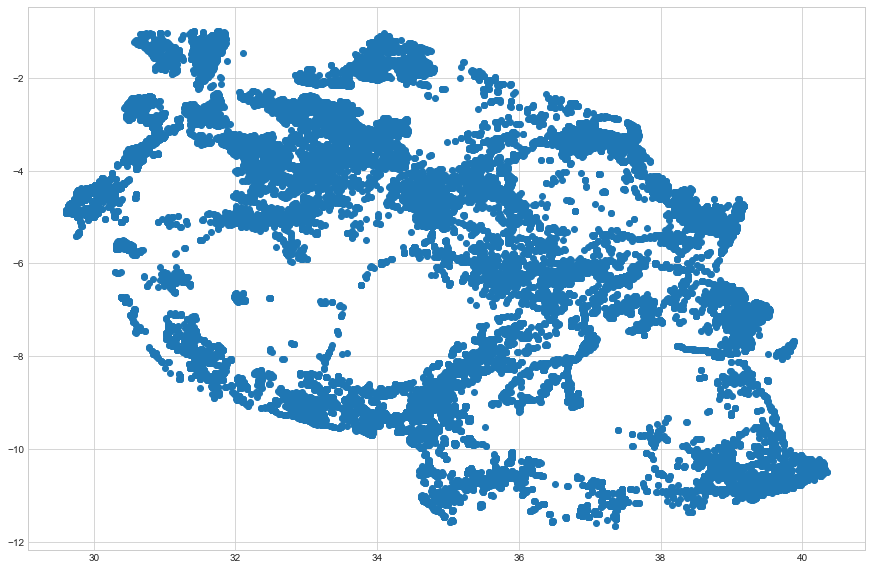

In [61]:
plt.figure(figsize = (15, 10))
loc = df.loc[df['longitude'] != 0, ['status_group', 'longitude', 'latitude']]
print(loc.head())
plt.scatter(loc['longitude'], loc['latitude'])

In [ ]:
gdf = gpd.GeoDataFrame(loc, geometry = geopandas.points_from_xy(loc.longitude, loc.latitude))
gdf.head()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'Africa'].plot(color = 'white', edgecolor = 'black')

gdf.plot(ax = ax, color = 'blue')

plt.show()

In [ ]:
gpd.datasets.available

In [ ]:
df.nunique()

# Modeling

### Defining useful functions

In [48]:
#Define Function to compare accuracy scores
def accuracy_comp(y_train, p_train, y_test, p_test):
    """This function compares the accuracy scores of train and test sets
    predictions"""
    
    train_accuracy = accuracy_score(y_train, p_train)
    test_accuracy = accuracy_score(y_test, p_test)
        
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    

### Preping the Data

In [49]:
#Create new dataframe for modeling
#Drop uninteresting columns
dfmod = df.drop(['id', 'status_group', 'wpt_name'], axis = 1)

In [50]:
#Define target
target = df['status_group']

In [51]:
#Defining categorical and cntinuous features
con_feats = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 
            'population', 'construction_year']
cat_feats = list(dfmod.drop(con_feats, axis = 1).columns)

In [52]:
#Drop categorical features with too many unique values
to_remove = ['funder', 'installer', 'subvillage', 'ward']
for label in to_remove:
    cat_feats.remove(label)

#Check list
print(cat_feats)

['basin', 'region', 'region_code', 'district_code', 'lga', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type']


In [53]:
#Create dummy variables
dummy = pd.get_dummies(df[cat_feats], drop_first = True)
dummy.shape

(59400, 241)

In [54]:
#Finalise dfmod for modeling
dfmod.drop(cat_feats, axis = 1, inplace = True)
dfmod.drop(to_remove, axis = 1, inplace = True)

dfmod = pd.concat ([dfmod, dummy], axis = 1)
dfmod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Columns: 247 entries, amount_tsh to waterpoint_type_other
dtypes: float64(3), int64(5), uint8(239)
memory usage: 20.1 MB


In [55]:
#Preview
dfmod.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,region_code,district_code,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_Arusha Urban,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Kongwa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Monduli,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Rungwe,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,public_meeting_True,public_meeting_True,scheme_management_none,scheme_management_other,scheme_management_parastatal,scheme_management_private operator,scheme_management_swc,scheme_management_trust,scheme_management_unknown,scheme_management_vwc,scheme_management_water authority,scheme_management_water board,scheme_management_wua,scheme_management_wug,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,sou

In [56]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(dfmod, target, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 247), (14850, 247), (44550,), (14850,))

In [57]:
#Instantial StandardScaler
scaler = StandardScaler()

#Transform the train and test sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#Convert to DataFrae
X_train = pd.DataFrame(X_train, columns = dfmod.columns)
X_train.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,region_code,district_code,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_Arusha Urban,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Kongwa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Monduli,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Rungwe,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,public_meeting_True,public_meeting_True,scheme_management_none,scheme_management_other,scheme_management_parastatal,scheme_management_private operator,scheme_management_swc,scheme_management_trust,scheme_management_unknown,scheme_management_vwc,scheme_management_water authority,scheme_management_water board,scheme_management_wua,scheme_management_wug,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,sou

### KNN

In [58]:
#Instantiate Classifier
KNN = KNeighborsClassifier()

#Fit model
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [59]:
#Predict
train_pred = KNN.predict(X_train)
test_pred = KNN.predict(X_test)

In [60]:
#Compare Accuracy Scores
accuracy_comp(y_train, train_pred, y_test, test_pred)

#Print Classification Report
print('\n Classification Report: \n', classification_report(y_test, test_pred))

Training Accuracy: 82.91%
Test Accuracy:     75.94%

 Classification Report: 
                          precision    recall  f1-score   support

             functional       0.76      0.86      0.81      7963
functional needs repair       0.46      0.29      0.35      1076
         non functional       0.79      0.72      0.75      5811

               accuracy                           0.76     14850
              macro avg       0.67      0.62      0.64     14850
           weighted avg       0.75      0.76      0.75     14850



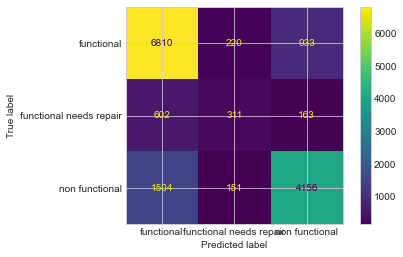

In [67]:
#Plot a confusion matrix
plot_confusion_matrix(KNN, X_test, y_test)

### Random Forest

In [76]:
#Instantiate RandomForest Classifier
forest = RandomForestClassifier()

In [78]:
#Use GridSerchCV to determine best parameters
rf_param_grid = {'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5] }

#Instantiate GridSearchCV
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv = 3)

#Fit to the data
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [79]:
#Check best params
print(rf_grid_search.best_params_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [92]:
#Instantiate and train RandomForest with the determined params
forest = RandomForestClassifier(n_estimators = 500, criterion = 'gini', max_depth = None, 
                                min_samples_leaf = 2, min_samples_split = 2)
forest.fit(X_train, y_train)

#Predict train and test sets
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

In [97]:
#Check accuracy score and classification report
accuracy_comp(y_train, train_pred, y_test, test_pred)
print('\n Classification Report: \n', classification_report(y_test, test_pred))

Training Accuracy: 88.0%
Test Accuracy:     77.71%

 Classification Report: 
                          precision    recall  f1-score   support

             functional       0.73      0.95      0.83      7963
functional needs repair       0.71      0.15      0.25      1076
         non functional       0.88      0.66      0.75      5811

               accuracy                           0.78     14850
              macro avg       0.78      0.59      0.61     14850
           weighted avg       0.79      0.78      0.76     14850



### Model Tuning

#### 1. Addressing Class Imbalance using SMOTE

In [75]:
#Instantiate and train
smote = SMOTE()

X_smote, y_smote = smote.fit_sample(X_train, y_train)

KeyError: 'Only the Series name can be used for the key in Series dtype mappings.'

#### 2. Feature Modification

In [ ]:
print('test')